# Enriched flagellins across biomes

This notebook will focus on phylogenetic analyses with differentially abundant (DA) flagellins previously identified between host-associated and free-living environments

### Set-up

In [2]:
library(tidyverse)
library(ggplot2)
library(ggsci)
library(viridis)
library(conflicted)
library(gridExtra)
library(vegan)
library(ape)
library(lattice)
library(permute)
library(grid) 
library(seqinr)
library("picante")
library("phylosignal")
library("phytools")
library(rentrez)

── Attaching packages ──────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   1.0.2
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.3.0     ✔ stringr 1.5.1
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ─────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: viridisLite

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:seqinr’:

    gls


The following object is masked from ‘package:dplyr’:

    collapse


Loading required package: maps


Attaching package: ‘maps’


The following object is masked from ‘package:viridis’:

    unemp


The following object is masked from ‘package:purrr’:

    map




In [3]:
conflict_prefer("filter","dplyr")
conflict_prefer("rename","dplyr")
conflict_prefer("mutate","dplyr")
conflict_prefer("count","dplyr")

[conflicted] Will prefer dplyr::filter over any other package.
[conflicted] Will prefer dplyr::rename over any other package.
[conflicted] Will prefer dplyr::mutate over any other package.
[conflicted] Will prefer dplyr::count over any other package.


### Import input files

## Non-rarefied / filtered results

In [10]:
#EdgeR results
DA.animals.env = read_tsv("seqs/DA.animals.env.tsv",col_names=T)
DA.animals.plants = read_tsv("seqs/DA.animal.plants.tsv",col_names=T)
DA.plants.env = read_tsv("seqs/DA.plants.env.tsv",col_names=T)
DA.host.env = read_tsv("seqs/DA.host.env.tsv",col_names=T)

Rows: 609 Columns: 13
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): Accession, Domain, Phylum, Class, Order, Family, Genus, Species, En...
dbl (4): logFC, logCPM, PValue, FDR

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 203 Columns: 13
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): Accession, Domain, Phylum, Class, Order, Family, Genus, Species, En...
dbl (4): logFC, logCPM, PValue, FDR

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 326 Columns: 13
── Column specif

In [11]:
#Flagellin multifasta
flagellins.markers.sb=seqinr::read.fasta("/ebio/abt3_projects/small_projects/aborbon/Thesis_FlagellinDiversity/1_shortbred/out.finalmap.faa",seqtype="AA")

In [92]:
flagellin.sizes.taxonomy = read_tsv("../../../flagellin_phylogeny//fla.sb.taxonomy.length.tsv",col_names=T) %>%
select(Accession,length,HVR_length,ncbi_phylum,genome_size)

Rows: 9963 Columns: 13
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): Accession, ncbi_phylum, Domain, Phylum, Class, Order, Family, Genus...
dbl (4): length, HVR_length, ncbi_taxid, genome_size

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [13]:
#Filter sequences for each set of DA flagellins
seqs.DA.animals.env = flagellins.markers.sb[c(which(names(flagellins.markers.sb) %in% DA.animals.env$Accession))]
seqs.DA.animals.plants = flagellins.markers.sb[c(which(names(flagellins.markers.sb) %in% DA.animals.plants$Accession))]
seqs.DA.plants.env = flagellins.markers.sb[c(which(names(flagellins.markers.sb) %in% DA.plants.env$Accession))]
seqs.DA.host.env = flagellins.markers.sb[c(which(names(flagellins.markers.sb) %in% DA.host.env$Accession))]

In [14]:
#Export sequences
write.fasta(sequences = seqs.DA.animals.env, names = names(seqs.DA.animals.env), nbchar = 80, file.out = "seqs/seqs.DA.animals.env.faa")
write.fasta(sequences = seqs.DA.animals.plants, names = names(seqs.DA.animals.plants), nbchar = 80, file.out = "seqs/seqs.DA.animals.plants.faa")
write.fasta(sequences = seqs.DA.plants.env, names = names(seqs.DA.plants.env), nbchar = 80, file.out = "seqs/seqs.DA.plants.env.faa")
write.fasta(sequences = seqs.DA.host.env, names = names(seqs.DA.host.env), nbchar = 80, file.out = "seqs/seqs.DA.host.env.faa")


In [89]:
names(DA.animals.env)

[1] "Accession"  "Domain"     "Phylum"     "Class"      "Order"     
 [6] "Family"     "Genus"      "Species"    "logFC"      "logCPM"    
[11] "PValue"     "FDR"        "EnrichedIn"

In [93]:
map.DA.animals.env = inner_join(DA.animals.env,flagellin.sizes.taxonomy,by="Accession")

In [94]:
head(map.DA.animals.env)

Accession,Domain,Phylum,Class,Order,Family,Genus,Species,logFC,logCPM,PValue,FDR,EnrichedIn,length,HVR_length,ncbi_phylum,genome_size
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
EEJ52905.1,d__Bacteria,p__Actinobacteriota,c__Actinomycetia,o__Actinomycetales,f__Actinomycetaceae,g__Mobiluncus,s__Mobiluncus mulieris,3.080322,11.98937,5.780637e-75,1.138786e-71,Environmental,511,271,Actinobacteria,2435166
OUT94870.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Parvibaculales,f__RS24,g__UBA7378,s__UBA7378 sp002689195,3.446868,11.46430,7.556581e-64,7.443232e-61,Environmental,671,431,Proteobacteria,1652246
KQT19785.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Beijerinckiaceae,g__Methylobacterium,s__Methylobacterium sp001423265,2.750747,11.26181,5.330136e-60,3.500123e-57,Environmental,569,329,Proteobacteria,4456718
KDR32911.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Caballeronia,s__Caballeronia zhejiangensis,3.268495,14.43158,1.497735e-52,7.376344e-50,Environmental,426,186,Proteobacteria,7666841
OAS88434.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Achromobacter,s__Achromobacter xylosoxidans,2.372564,11.40918,1.161668e-42,4.576974e-40,Environmental,506,266,Proteobacteria,5876049
WP_068024403.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Xanthobacteraceae,g__Z2-YC6860,s__Z2-YC6860 sp001579845,2.629497,11.07332,1.590802e-40,5.223134e-38,Environmental,274,34,Proteobacteria,8193889


In [95]:
#Create mapping files
map.DA.animals.env = inner_join(DA.animals.env,flagellin.sizes.taxonomy,by="Accession")
map.DA.animals.plants = inner_join(DA.animals.plants,flagellin.sizes.taxonomy,by="Accession")
map.DA.plants.env = inner_join(DA.plants.env,flagellin.sizes.taxonomy,by="Accession")
map.DA.host.env = inner_join(DA.host.env,flagellin.sizes.taxonomy,by="Accession")

In [96]:
nrow(map.DA.animals.plants)

[1] 203

In [97]:
#Write mapping files
write_tsv(map.DA.animals.env,"seqs/map.DA.animals.env.tsv")
write_tsv(map.DA.animals.plants,"seqs/map.DA.animals.plants.tsv")
write_tsv(map.DA.plants.env,"seqs/map.DA.plants.env.tsv")
write_tsv(map.DA.host.env,"seqs/map.DA.host.env.tsv")

In [98]:
#Count the number of enriched flagellins per pairwise group-comparison
dplyr::count(map.DA.animals.env,EnrichedIn)
dplyr::count(map.DA.animals.plants,EnrichedIn)
dplyr::count(map.DA.plants.env,EnrichedIn)
dplyr::count(map.DA.host.env,EnrichedIn)

EnrichedIn,n
<chr>,<int>
Animals,122
Environmental,487


EnrichedIn,n
<chr>,<int>
Animals,121
Plants,82


EnrichedIn,n
<chr>,<int>
Environmental,283
Plants,43


EnrichedIn,n
<chr>,<int>
Environmental,513
Host-associated,110


### Subset Proteobacteria from animals/plants comparison

In [99]:
DA.proteo.animals.plants = filter(map.DA.animals.plants,Phylum=="p__Proteobacteria")

In [100]:
nrow(DA.proteo.animals.plants)

[1] 111

In [101]:
seqs.DA.proteo.animals.plants = flagellins.markers.sb[c(which(names(flagellins.markers.sb) %in% DA.proteo.animals.plants$Accession))]

In [102]:
length(seqs.DA.proteo.animals.plants)

[1] 111

In [103]:
write.fasta(sequences = seqs.DA.proteo.animals.plants, names = names(seqs.DA.proteo.animals.plants), nbchar = 80, file.out = "seqs/seqs.DA.proteo.animals.plants.faa")

In [104]:
map.proteo.animals.plants = filter(map.DA.animals.plants)

## Define the two datasets

In [3]:
flagellin.sizes.taxonomy = read_tsv("../../../flagellin_phylogeny//fla.sb.taxonomy.length.tsv",col_names=T) %>%
select(Accession,length,HVR_length,ncbi_phylum,genome_size)

Rows: 9963 Columns: 13
── Column specification ─────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): Accession, ncbi_phylum, Domain, Phylum, Class, Order, Family, Genus...
dbl (4): length, HVR_length, ncbi_taxid, genome_size

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
getwd()

[1] "/ebio/abt3_projects2/Flagellin_Diversity/code/notebooks/shortbred/edgeR/subsampled_opt1"

In [9]:
derepAll = read_tsv("uniqueFlagellinsBiome/all_together//allUnique_metadata.tsv")

Rows: 41 Columns: 29
── Column specification ─────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (13): Accession, category.x, category.y, category, UniqueIn, ncbi_phylum...
dbl (13): totalCount_Animal, NoSamples.x, ProportionIn_Animal, totalCount_En...
lgl  (3): PresentIn_Animal, PresentIn_Environmental, PresentIn_Plants

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [10]:
head(derepAll)

Accession,category.x,totalCount_Animal,NoSamples.x,ProportionIn_Animal,PresentIn_Animal,category.y,totalCount_Environmental,NoSamples.y,ProportionIn_Environmental,⋯,ncbi_taxid,ncbi_phylum,Domain,Phylum,Class,Order,Family,Genus,Species,genome_size
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
WP_022758790.1,Animal,111,178,0.0009871844,TRUE,Environmental,0,99,0,⋯,831,Firmicutes,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Pseudobutyrivibrio,s__Pseudobutyrivibrio fibrisolvens_A,3164379
ONG15595.1,Animal,479,178,0.0042600119,TRUE,Environmental,0,99,0,⋯,562,Proteobacteria,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,g__Escherichia,s__Escherichia coli_D,5232730
EGC94816.1,Animal,941,178,0.0083688334,TRUE,Environmental,0,99,0,⋯,981367,Proteobacteria,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,g__Escherichia,s__Escherichia fergusonii,4866106
CBL40883.1,Animal,155,178,0.0013785007,TRUE,Environmental,0,99,0,⋯,245014,Firmicutes,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__CAG-81,s__CAG-81 sp900066535,3601020
OUP02704.1,Animal,328,178,0.0029170854,TRUE,Environmental,0,99,0,⋯,1965587,Firmicutes,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Oscillospirales,f__Acutalibacteraceae,g__Hydrogeniiclostridium,s__Hydrogeniiclostridium sp002160025,3721138
OLR54261.1,Animal,58,178,0.0005158261,TRUE,Environmental,0,99,0,⋯,1261634,Firmicutes,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__14-2,s__14-2 sp001940225,3360661


In [ ]:
DA.animals = filter(derepAll,UniqueIn=="Animal")
DA.plants = filter(derepAll,UniqueIn=="Plants")
DA.env = filter(derepAll,UniqueIn=="Env")

In [106]:
#Write datasets of flagellins enriched in each biome
write_tsv(DA.animals,"DA.animals.tsv")
write_tsv(DA.plants,"DA.plants.tsv")
write_tsv(DA.env,"DA.env.tsv")
write_tsv(DA.host,"DA.host.tsv")

In [12]:
nrow(DA.animals)
nrow(DA.plants)
nrow(DA.env)

[1] 18

[1] 11

[1] 12

In [36]:
#set.all=read.delim("../flags.tax.nonrareAll.tsv")%>%
    inner_join(flagellin.sizes.taxonomy,by="Accession")

In [13]:
allFlas = readRDS("../../filter_taxa_All_count_subsampled.median.rds")

In [14]:
#Define the datasets
set.animals=DA.animals
set.plants=DA.plants
set.env=DA.env
set.all=rownames_to_column(as.data.frame(allFlas@tax_table),var="Accession")%>%
    inner_join(flagellin.sizes.taxonomy,by="Accession")

Loading required package: phyloseq

Found more than one class "Annotated" in cache; using the first, from namespace 'RNeXML'

Also defined by ‘S4Vectors’

Found more than one class "Annotated" in cache; using the first, from namespace 'RNeXML'

Also defined by ‘S4Vectors’

Found more than one class "Annotated" in cache; using the first, from namespace 'RNeXML'

Also defined by ‘S4Vectors’

Found more than one class "Annotated" in cache; using the first, from namespace 'RNeXML'

Also defined by ‘S4Vectors’

Found more than one class "Annotated" in cache; using the first, from namespace 'RNeXML'

Also defined by ‘S4Vectors’

Found more than one class "Annotated" in cache; using the first, from namespace 'RNeXML'

Also defined by ‘S4Vectors’



##### Import phylogeny

In [15]:
#Import full set phylogeny

tre.all=allFlas@phy_tree#read.tree("flags.nonrareAll.tre")
phy=midpoint.root(tre.all)
tre.all


Phylogenetic tree with 1971 tips and 1970 internal nodes.

Tip labels:
  WP_018305791.1, KJS48310.1, EHQ91627.1, KRE97958.1, WP_039230967.1, ESU34160.1, ...
Node labels:
  0.881, 0.842, 0.893, 0.836, 0.585, 0.807, ...

Rooted; includes branch lengths.

##### Create traits dataframe

In [18]:
#Create traits dataframe
traits.unique= set.all %>% 
    mutate(unique.animals=if_else(tre.all$tip.label%in%set.animals$Accession,1,0))%>%
    mutate(unique.plants=if_else(tre.all$tip.label%in%set.plants$Accession,1,0))%>%
    mutate(unique.env=if_else(tre.all$tip.label%in%set.env$Accession,1,0))%>%
    select(Accession,unique.animals,unique.plants,unique.env,length,genome_size)

head(traits.unique)

,Accession,unique.animals,unique.plants,unique.env,length,genome_size
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,WP_018305791.1,0,0,0,382,5666696
2,KJS48310.1,0,0,0,1153,6027195
3,EHQ91627.1,0,0,0,843,5660978
4,KRE97958.1,0,0,0,555,8257780
5,WP_039230967.1,0,0,0,478,3825819
6,ESU34160.1,0,0,0,455,4696869


##### Create trait list for phylosignal object

In [19]:
#Create trait list for phylosignal object
dat <- list()
dat$unique.animals <- traits.unique$unique.animals
dat$unique.plants <- traits.unique$unique.plants
dat$unique.env <- traits.unique$unique.env
dat$SeqLength <- traits.unique$length
dat$genome_size <- traits.unique$genome_size
dat <- as.data.frame(dat)
rownames(dat) = traits.unique$Accession
head(dat)

,unique.animals,unique.plants,unique.env,SeqLength,genome_size
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WP_018305791.1,0,0,0,382,5666696
KJS48310.1,0,0,0,1153,6027195
EHQ91627.1,0,0,0,843,5660978
KRE97958.1,0,0,0,555,8257780
WP_039230967.1,0,0,0,478,3825819
ESU34160.1,0,0,0,455,4696869


In [20]:
nrow(dat)

[1] 1971

##### Create phylosignal object

In [21]:
#Create phylosignal object
p4d <- phylobase::phylo4d(phy, dat)

Warning message in checkTree(object):
“Labels are not unique. ”
Warning message in checkTree(object):
“Labels are not unique. ”


##### Testing phylosignal

In [22]:
#Test phylosignal hypothesis using Pagel's Lambda method for categorical traits
phylosignal.finalset=phyloSignal(p4d,methods=c("Lambda","Cmean"))
phylosignal.finalset

Warning message in checkTree(object):
“Labels are not unique. ”
Warning message in checkTree(object):
“Labels are not unique. ”
Warning message in checkTree(object):
“Labels are not unique. ”


,Cmean,Lambda
,<dbl>,<dbl>
unique.animals,7.872183e-02,0.08801019
unique.plants,7.488330e-02,0.09831339
unique.env,-6.772673e-05,0.88349592
SeqLength,6.026298e-01,1.13707864
genome_size,5.985572e-01,0.94838019
,Cmean,Lambda
,<dbl>,<dbl>
unique.animals,0.003,0.001
unique.plants,0.018,0.001


In [23]:
flag.lipa <- lipaMoran(p4d)

Warning message in checkTree(object):
“Labels are not unique. ”
Warning message in .local(x, ...):
“Non-unique or missing labels found, labels cannot be coerced to tdata row.names. Use the label.type argument to include labels as first column of data.”
Warning message in checkTree(object):
“Labels are not unique. ”
Warning message in checkTree(object):
“Labels are not unique. ”
Warning message in checkTree(object):
“Labels are not unique. ”


In [124]:
#barplot.phylo4d(flag.lipa.p4d, trait = "seqLength",bar.col=(flag.lipa$p.value < 0.05) + 1, center = FALSE , scale = FALSE,label.type=T)

In [125]:
host.env.dat = map.DA.host.env %>% 
select(Accession,HVR_length,genome_size)
rownames(host.env.dat) = host.env.dat$Accession
head(host.env.dat)

Warning message:
“Setting row names on a tibble is deprecated.”


Accession,HVR_length,genome_size
<chr>,<dbl>,<dbl>
OUT94870.1,431,1652246
EEJ52905.1,271,2435166
KDR32911.1,186,7666841
KQT19785.1,329,4456718
OQW31935.1,35,3659024
ORC34218.1,42,4216685


In [126]:
#phy.host.env = prune.sample(,phy)
#prunedphy <- prune.sample(comm, phy)
#p4d <- phylobase::phylo4d(phy, dat)

### Using SES of MPD (Mean Pairwise Distance) and MNTD (Mean Nearest Taxon Distance) implemented in Picante

##### Phylogeny

In [24]:
phy


Phylogenetic tree with 1971 tips and 1970 internal nodes.

Tip labels:
  OEU73186.1, WP_018305791.1, KJS48310.1, EHQ91627.1, KRE97958.1, WP_039230967.1, ...
Node labels:
  Root, 0.713, 0.411, 0.569, 0.945, 0.449, ...

Rooted; includes branch lengths.

##### Community data

In [25]:
all.flas=rep(1,nrow(traits.unique))
unique.plants =rep(if_else(traits.unique$unique.plants==1,1,0))
unique.env =rep(if_else(traits.unique$unique.env==1,1,0))



comm.data=traits.unique %>%
  select(Accession,unique.animals)%>%
  mutate(Sample="unique.animals")%>%
  distinct(Accession,.keep_all=T)%>%
  spread(Accession,unique.animals)%>%
  column_to_rownames(var= "Sample")%>%
  rbind(unique.plants)%>%
  rbind(unique.env)
  
row.names(comm.data) <- c("unique.animals","unique.plants","unique.env")

comm=as.matrix(comm.data[1:nrow(comm.data),2:ncol(comm.data)])

comm.data

,AAA62844.1,AAG14365.1,AAG34566.1,AAK24938.1,AAP77961.1,AAR10646.1,AAR10729.1,AAT06254.1,AAW75835.1,AAZ64437.1,⋯,WP_118137284.1,WP_118178391.1,WP_118183865.1,WP_118202691.1,WP_118280384.1,WP_118508201.1,WP_118558985.1,WP_118680381.1,WP_118680383.1,WP_118710912.1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
unique.animals,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
unique.plants,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
unique.env,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


##### Trait data

In [26]:
traits= dat
head(traits)

,unique.animals,unique.plants,unique.env,SeqLength,genome_size
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WP_018305791.1,0,0,0,382,5666696
KJS48310.1,0,0,0,1153,6027195
EHQ91627.1,0,0,0,843,5660978
KRE97958.1,0,0,0,555,8257780
WP_039230967.1,0,0,0,478,3825819
ESU34160.1,0,0,0,455,4696869


##### Root phylogeny by midpoint

In [27]:
prunedphy <- prune.sample(comm, phy)
rooted.prunedphy=midpoint.root(prunedphy)

##### Plot distribution of selected taxa in each dataset across the phylogeny of top abundant (n=1263)

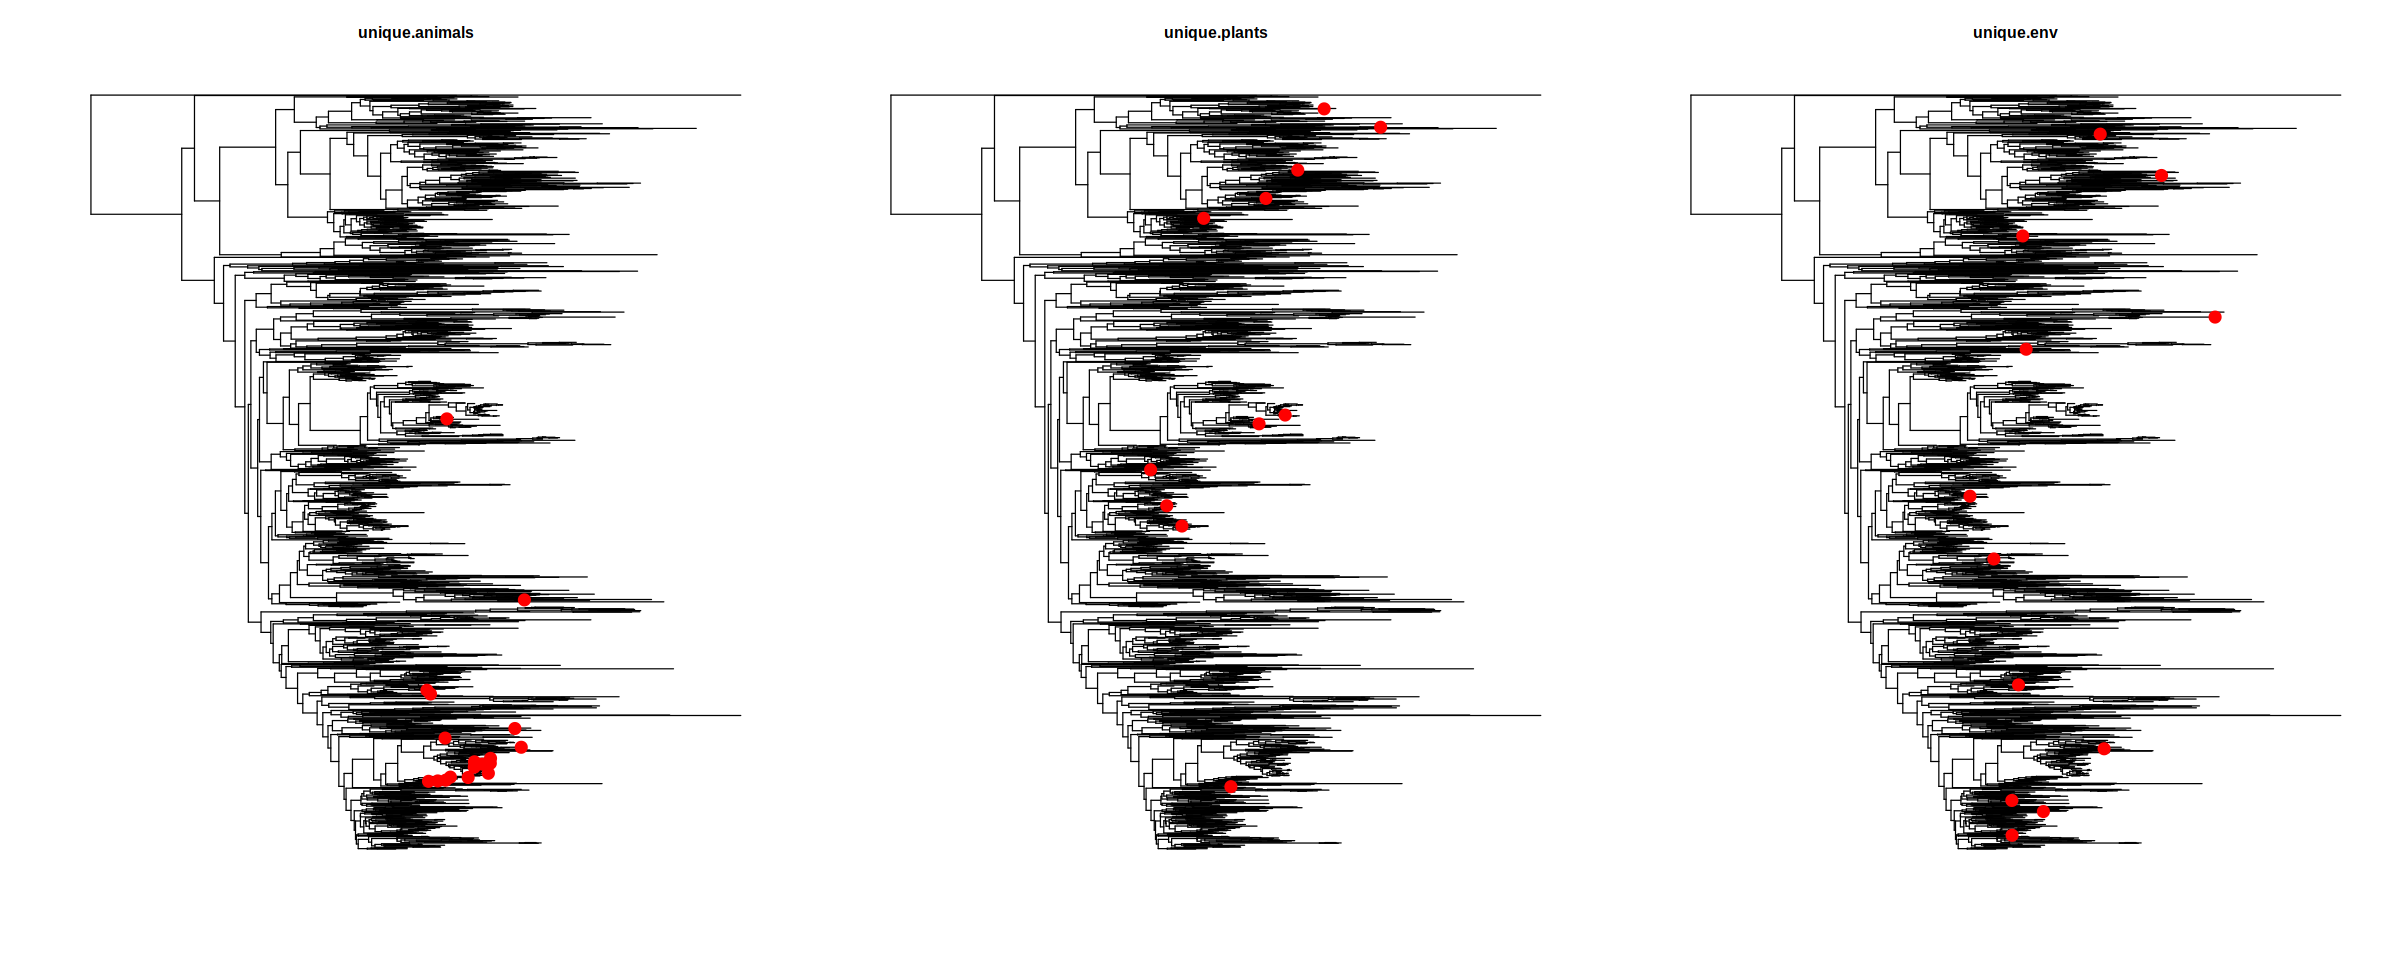

In [28]:
options(repr.plot.width=20,repr.plot.height=8)
par(mfrow = c(1, 3))
for (i in row.names(comm)) {plot(phy, show.tip.label = FALSE, main = i)
  tiplabels(tip = which(phy$tip.label %in% names(which(comm [i, ] > 0))),
pch=19, cex=2,col="red")
}

##### Calculate phylogenetic diversity

In [29]:
#pd
phy.div=pd(comm,phy,include.root=TRUE)
phy.div

,PD,SR
,<dbl>,<dbl>
unique.animals,9.031818,18
unique.plants,9.927756,11
unique.env,11.261880,12


##### Calculate null models of community assembly

In [82]:
#Create phylogeny distance matrix (MDP and MNTD require a matrix as input)
#phydist=cophenetic.phylo(phy)
#phydist

#Using MDP measure (MEAN PAIRWISE DISTANCE)
ses.mpd.result <- ses.mpd(comm, phydist, null.model="taxa.labels", abundance.weighted=FALSE, runs=1000)



#Using standardized effect size of phylogenetic diversity (Faith's PD)
ses.pd <- ses.pd(samp = comm, 
                        tree = phy, 
                        null.model = "taxa.labels", 
                        runs = 1000)


#Using MNTD measure (MEAN NEAREST TAXON DISTANCE)
ses.mntd.result <- ses.mntd(comm, phydist, null.model="taxa.labels",abundance.weighted=FALSE, runs=1000)


In [83]:
ses.mpd.result <- ses.mpd(comm, phydist, null.model="taxa.labels", abundance.weighted=FALSE, runs=1000)


In [84]:
ses.mpd.result =ses.mpd.result %>% rownames_to_column(var="biome")
ses.pd = ses.pd %>% rownames_to_column(var="biome")
ses.mntd.result =ses.mntd.result %>% rownames_to_column(var="biome")

In [88]:
ses.mpd.result
ses.pd
ses.pd

biome,ntaxa,mpd.obs,mpd.rand.mean,mpd.rand.sd,mpd.obs.rank,mpd.obs.z,mpd.obs.p,runs
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
unique.animals,18,1.263102,2.196251,0.1912956,1,-4.8780497,0.000999001,1000
unique.plants,11,2.318629,2.192165,0.2538858,684,0.4981133,0.683316683,1000
unique.env,12,2.273695,2.191931,0.2501692,622,0.3268325,0.621378621,1000


biome,ntaxa,pd.obs,pd.rand.mean,pd.rand.sd,pd.obs.rank,pd.obs.z,pd.obs.p,runs
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
unique.animals,18,9.031818,15.13658,1.504592,1,-4.0574232,0.000999001,1000
unique.plants,11,9.927756,10.44042,1.173279,327,-0.4369527,0.326673327,1000
unique.env,12,11.261880,11.19428,1.278307,535,0.0528784,0.534465534,1000


biome,ntaxa,pd.obs,pd.rand.mean,pd.rand.sd,pd.obs.rank,pd.obs.z,pd.obs.p,runs
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
unique.animals,18,9.031818,15.13658,1.504592,1,-4.0574232,0.000999001,1000
unique.plants,11,9.927756,10.44042,1.173279,327,-0.4369527,0.326673327,1000
unique.env,12,11.261880,11.19428,1.278307,535,0.0528784,0.534465534,1000


In [111]:
ses.phylodiv.unique = inner_join(ses.mpd.result,ses.pd,by="biome")%>%
                        inner_join(ses.mntd.result,by="biome")

In [112]:
ses.phylodiv.unique

biome,ntaxa.x,mpd.obs,mpd.rand.mean,mpd.rand.sd,mpd.obs.rank,mpd.obs.z,mpd.obs.p,runs.x,ntaxa.y,⋯,pd.obs.p,runs.y,ntaxa,mntd.obs,mntd.rand.mean,mntd.rand.sd,mntd.obs.rank,mntd.obs.z,mntd.obs.p,runs
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,⋯,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
unique.animals,18,1.263102,2.196251,0.1912956,1,-4.8780497,0.000999001,1000,18,⋯,0.000999001,1000,18,0.6588721,1.171844,0.1533703,1,-3.3446638,0.000999001,1000
unique.plants,11,2.318629,2.192165,0.2538858,684,0.4981133,0.683316683,1000,11,⋯,0.326673327,1000,11,1.1568969,1.316345,0.2038087,219,-0.7823418,0.218781219,1000
unique.env,12,2.273695,2.191931,0.2501692,622,0.3268325,0.621378621,1000,12,⋯,0.534465534,1000,12,1.3266314,1.296882,0.1943832,571,0.1530474,0.570429570,1000


In [87]:
write_tsv(ses.phylodiv.unique,"../../../FlagellinDiversity/output_files/ses.phylo.div.uniqueBiome.tsv")

In [80]:
df.comm.assembly. = data.frame(biome = c("Animals","Plants","FL"),
                             mpd = c(1.263102,2.318629,2.273695),
                             pd = c(9.031818,9.927756,11.261880),
                             mntd = c(0.6588721,1.1568969,1.3266314))

In [11]:
library(reshape2)
library(ggplot2)
library(ggsci)

In [113]:
df.comm.plot = melt(ses.phylodiv.unique)

Using biome as id variables



In [91]:
melted.mpd = melt(ses.mpd.result)
melted.mpd

Using biome as id variables



biome,variable,value
<chr>,<fct>,<dbl>
unique.animals,ntaxa,1.800000e+01
unique.plants,ntaxa,1.100000e+01
unique.env,ntaxa,1.200000e+01
unique.animals,mpd.obs,1.263102e+00
unique.plants,mpd.obs,2.318629e+00
unique.env,mpd.obs,2.273695e+00
unique.animals,mpd.rand.mean,2.196251e+00
unique.plants,mpd.rand.mean,2.192165e+00
unique.env,mpd.rand.mean,2.191931e+00


In [94]:
obs.mpd =melted.mpd %>%
    filter(variable%in%c("mpd.obs.z","mpd.obs.p"))

In [95]:
obs.mpd

biome,variable,value
<chr>,<fct>,<dbl>
unique.animals,mpd.obs.z,-4.878049734
unique.plants,mpd.obs.z,0.498113319
unique.env,mpd.obs.z,0.326832508
unique.animals,mpd.obs.p,0.000999001
unique.plants,mpd.obs.p,0.683316683
unique.env,mpd.obs.p,0.621378621


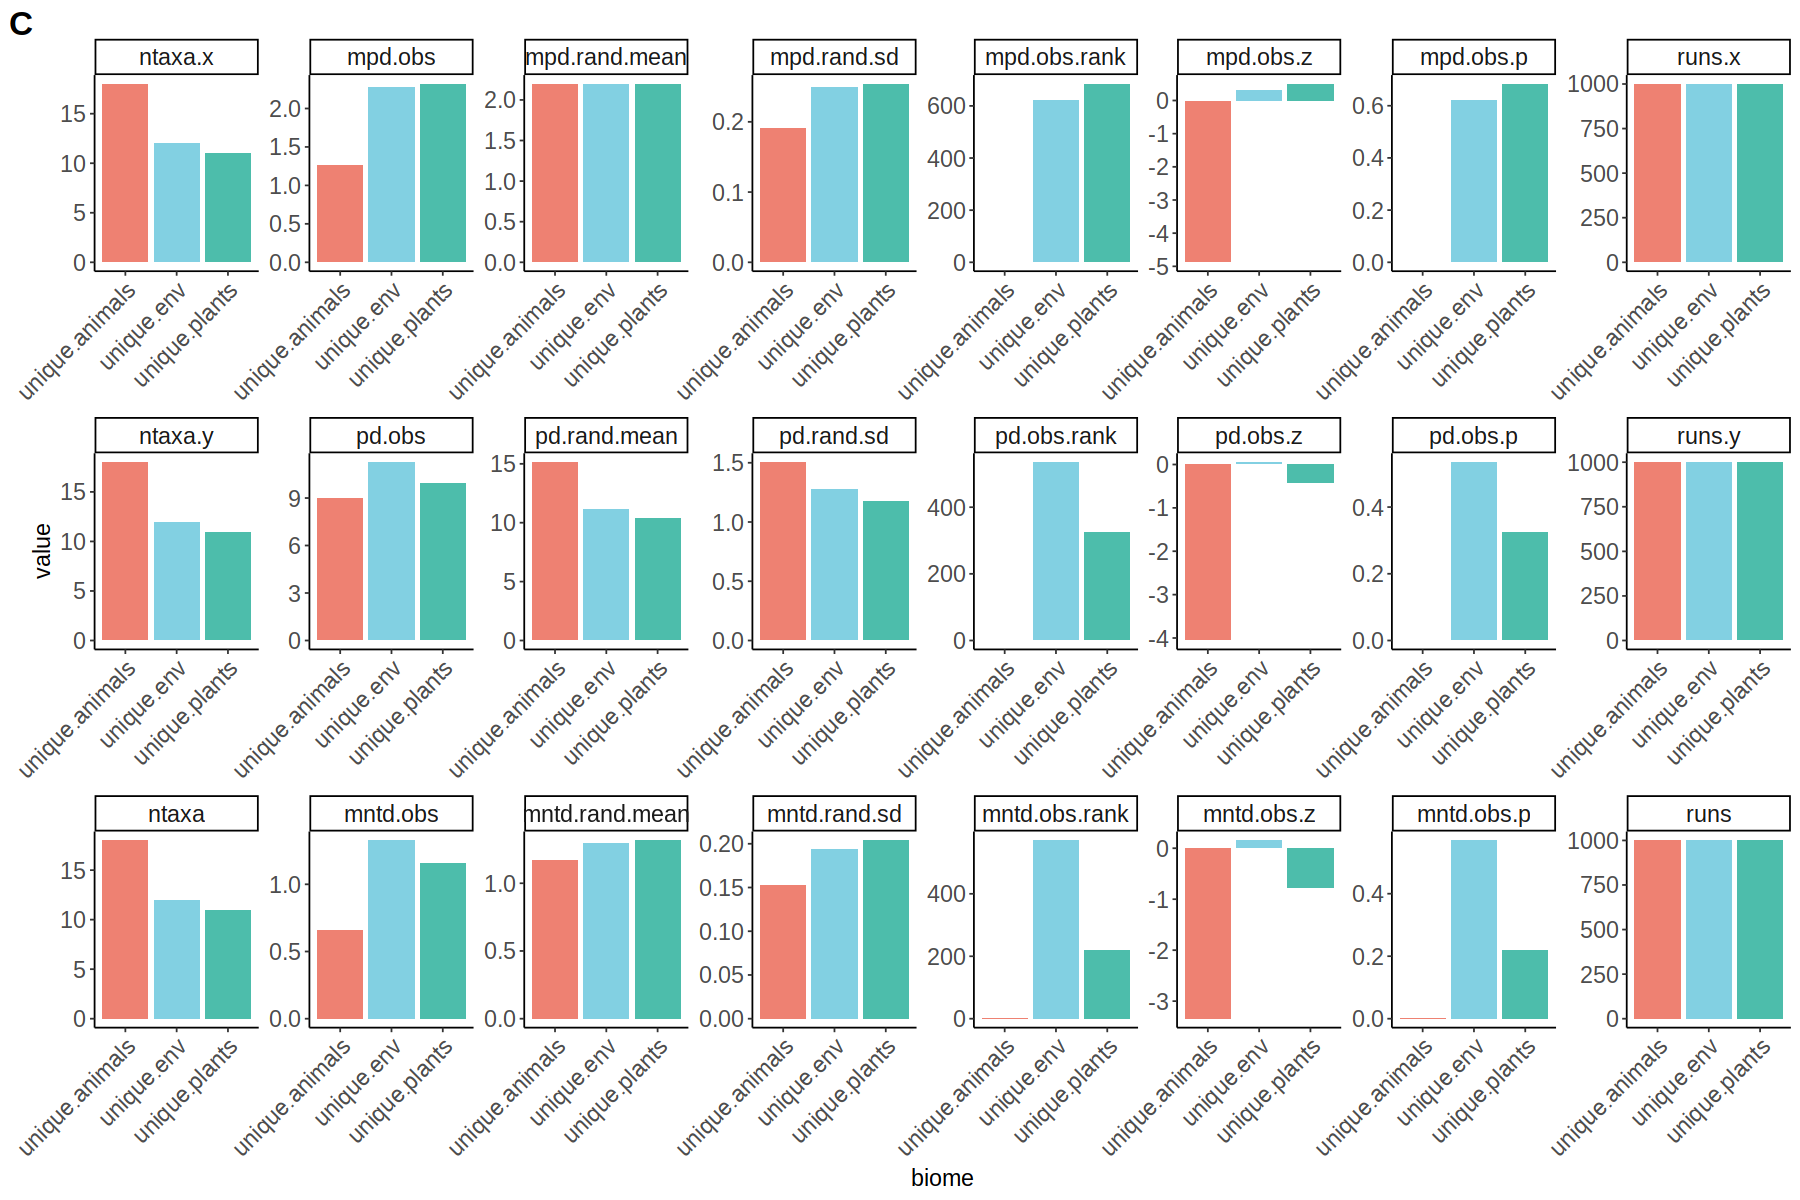

In [115]:
options(repr.plot.width=15,repr.plot.height=10)
ggplot(data=df.comm.plot,aes(x=biome,y=value,fill=biome))+
geom_bar(stat="identity",position = "dodge",alpha=0.7)+
facet_wrap(~variable,scales = "free",nrow=3)+
scale_fill_npg()+
theme_classic()+
theme(axis.title.x = element_text(size=14),
     axis.title.y = element_text(size=14),
     axis.text = element_text(size=14),
      axis.text.x = element_text(size=14,angle=45,hjust=1),
     strip.text.x = element_text(size=14),
     legend.position="none",
     plot.tag = element_text(size=20,face="bold"))+
     labs(tag="Biome-specific flagellins")+
  guides(fill = guide_legend(title = "EnrichedIn"))+
  labs(tag = "C")

### Figures thesis

In [4]:
colors.biome = read_tsv("../../../FlagellinDiversity/Figures//colors.map.tsv")

Rows: 11 Columns: 2
── Column specification ─────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): biome, color

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [21]:
colors.biome1 = colors.biome %>%
        filter(biome%in%c("Environmental","Plants","Animal"))%>%
        mutate(biome=str_replace_all(biome,"Environmental","FL"))

In [45]:
df.comm.assemblyUnique = data.frame(biome = c("Animal","Plants","FL"),
                             MPD = c(1.263102,2.318629,2.273695),
                             PD = c(9.031818,9.927756,11.261880),
                             MNTD = c(0.6588721,1.1568969,1.3266314))

In [47]:
df.comm.assemblyUnique = melt(df.comm.assemblyUnique)

Using biome as id variables



In [50]:
df.comm.assemblyUnique$biome <- factor(df.comm.assemblyUnique$biome, levels = c("Animal", "Plants", "FL"))

In [46]:
df.comm.assemblyComplete = data.frame(biome = c("Animal","Plants","FL"),
                             MPD = c(1.782301,2.235903,2.251793),
                             PD = c(37.94618,48.29071,196.43300),
                             MNTD = c(0.3751027,0.7542808,0.4986674))

In [48]:
df.comm.assemblyComplete = melt(df.comm.assemblyComplete)

Using biome as id variables



In [49]:
df.comm.assemblyComplete$biome <- factor(df.comm.assemblyComplete$biome, levels = c("Animal", "Plants", "FL"))

In [75]:
options(repr.plot.width=8,repr.plot.height=5)
fig14.a = ggplot(data=df.comm.assemblyComplete,aes(x=biome,y=value,fill=biome))+
geom_bar(stat="identity",position = "dodge",alpha=0.7)+
facet_wrap(~variable,scales = "free")+
scale_fill_manual(values = colors.biome1$color,
                 limits = colors.biome1$biome)+
theme_classic()+
theme(axis.title.x = element_blank(),
     axis.title.y = element_text(size=18),
     axis.text = element_text(size=14),
      axis.text.x = element_text(size=14),#,angle=45,hjust=1),
     strip.text.x = element_text(size=20,face="bold"),
     legend.position="none",
     plot.tag = element_text(size=20,face="bold"),
     plot.title = element_text(face="bold",size=20))+
  labs(tag = "A")+
ggtitle("Complete set")+
ylab("Phylogenetic distance")

In [78]:
options(repr.plot.width=8,repr.plot.height=5)
fig14.b = ggplot(data=df.comm.assemblyUnique,aes(x=biome,y=value,fill=biome))+
geom_bar(stat="identity",position = "dodge",alpha=0.7)+
facet_wrap(~variable,scales = "free")+
scale_fill_manual(values = colors.biome1$color,
                 limits = colors.biome1$biome)+
theme_classic()+
theme(axis.title.x = element_text(size=18),
     axis.title.y = element_text(size=18),
     axis.text = element_text(size=14),
      axis.text.x = element_text(size=14),#,angle=45,hjust=1),
     strip.text.x = element_text(size=20,face="bold"),
     legend.position="none",
     plot.tag = element_text(size=20,face="bold"),
     plot.title = element_text(face="bold",size=20))+
  labs(tag = "B")+
xlab("Biome")+
ggtitle("Biome-specific set")+
ylab("Phylogenetic distance")

In [79]:
lay.m <- rbind(c(1,1),
               c(2,2))
grobs.plots.m = list(fig14.a,fig14.b)

In [68]:
figures_path = "/ebio/abt3_projects2/Flagellin_Diversity/code/notebooks/FlagellinDiversity/Figures"

In [80]:
#file("/ebio/abt3_projects2/Flagellin_Diversity/code/notebooks/FlagellinDiversity/Figures/Figure1.pdf")
pdf(file.path(figures_path,"Figure14.pdf"), width = 14, height = 14)
grid.arrange(grobs = grobs.plots.m , layout_matrix = lay.m )
dev.off()

png 
  2

In [81]:
#file("/ebio/abt3_projects2/Flagellin_Diversity/code/notebooks/FlagellinDiversity/Figures/Figure1.pdf")
png(file.path(figures_path,"Figure14.png"), width = 600, height = 600)
grid.arrange(grobs = grobs.plots.m , layout_matrix = lay.m )
dev.off()

png 
  2